In [1]:
# lets start with importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, make_scorer, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
# lets read the dataset
df = pd.read_csv('C:/Users/BatuhanYILMAZ/Desktop/staj/project_1/datasets/preprocessed_MinMax.csv')
df.head()

,age,balance,day,duration,campaign,job,month,marital_divorced,marital_married,marital_single,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,0.519481,0.092259,0.133333,0.053070,0.0,4,8,0,1,0,...,1,0,0,0,1,0,0,0,1,0
1,0.337662,0.073067,0.133333,0.030704,0.0,9,8,0,0,1,...,1,0,0,0,1,0,0,0,1,0
2,0.194805,0.072822,0.133333,0.015453,0.0,2,8,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,0.376623,0.086476,0.133333,0.018707,0.0,1,8,0,1,0,...,1,0,0,0,1,0,0,0,1,0
4,0.194805,0.072812,0.133333,0.040260,0.0,11,8,0,0,1,...,1,0,0,0,1,0,0,0,1,0


In [3]:
# lets divide the dataset into independent-dependent variables
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]

In [4]:
# split the dataset into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Boosting algorithms might be sensitive against the imbalanced datasets as well. So, we will use over-under sampling
# just as we have done for the logistic regression here.

rus_1 = RandomUnderSampler(sampling_strategy=1, random_state=42)  # 0.5 to balance class 0 to 50% of class 1
X_train_under_sample_1, y_train_under_sample_1 = rus_1.fit_resample(X_train, y_train)
# Count the number of instances of each class after undersampling
print("Class 0 count:", len(X_train_under_sample_1[y_train_under_sample_1 == 0]))
print("Class 1 count:", len(X_train_under_sample_1[y_train_under_sample_1 == 1]))

Class 0 count: 4198
Class 1 count: 4198


In [6]:
# now, we can follow the path we took in previous algorithms and implement the grid search for xgboost
xgb_model = xgb.XGBClassifier()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}

# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    xgb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the training data
grid_search.fit(X_train_under_sample_1, y_train_under_sample_1)

# Get the best estimator from the grid search
best_model_xgb = grid_search.best_estimator_
best_param_xgb = grid_search.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores_xgb = grid_search.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val_xgb = cross_val_recall_scores_xgb.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred_xgb = best_model_xgb.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_param_xgb)
print("Average Recall from Cross-Validation:", avg_recall_cross_val_xgb)

# Print classification report
print(classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Average Recall from Cross-Validation: 0.882322492763494
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7952
           1       0.42      0.89      0.57      1091

    accuracy                           0.84      9043
   macro avg       0.70      0.86      0.73      9043
weighted avg       0.91      0.84      0.86      9043



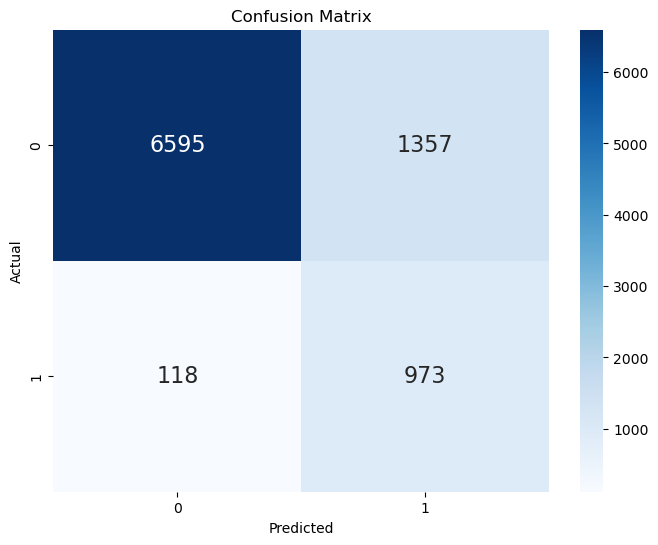

In [7]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred_xgb)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

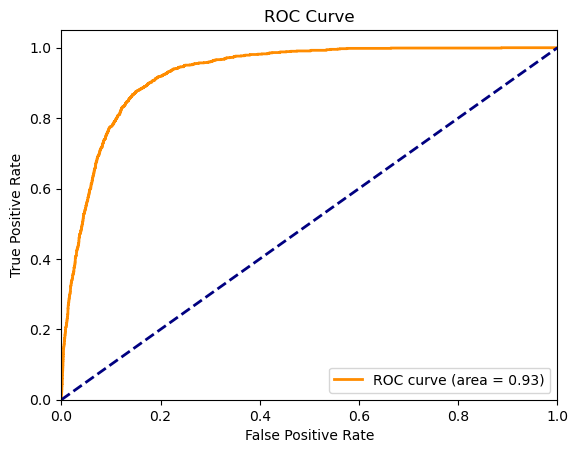

In [8]:
# lets see the ROC curve to see the model's performance at varying levels of discrimination.
y_prob = best_model_xgb.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

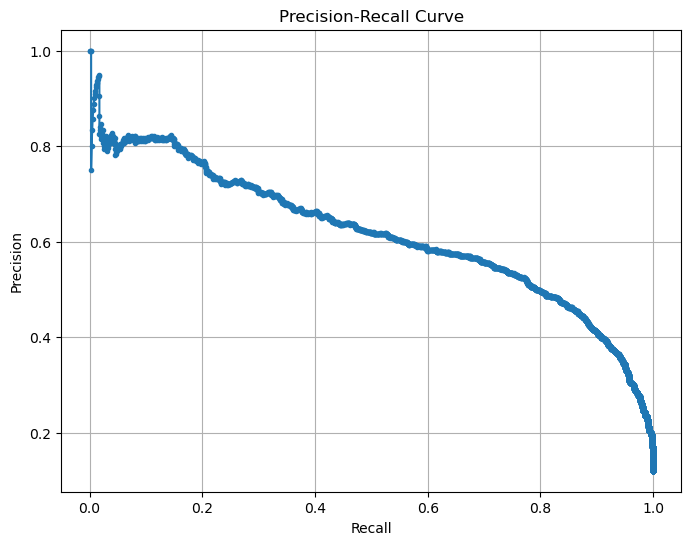

In [9]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_xgb.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

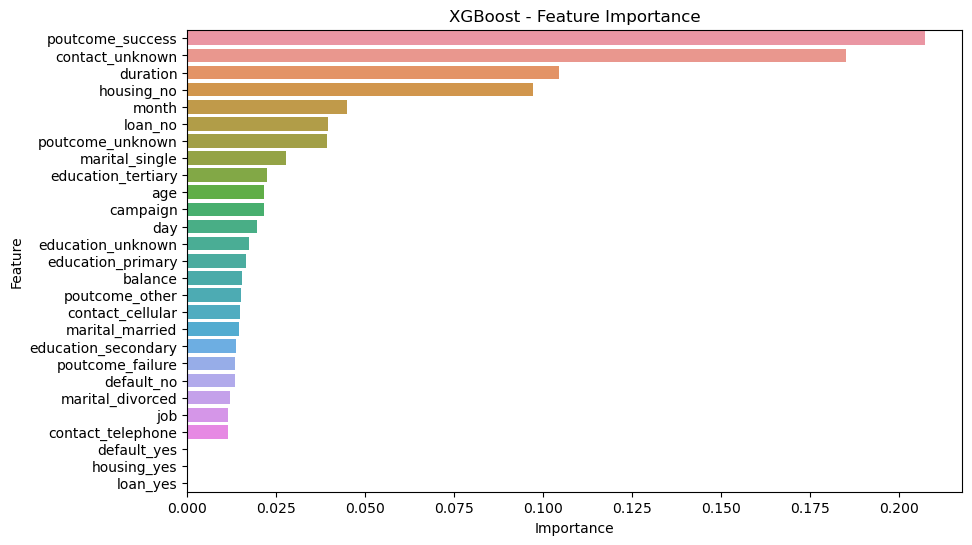

In [10]:
# lets also see the influence of each feature on the output
# Get feature importances
feature_importances = best_model_xgb.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train_under_sample_1.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("XGBoost - Feature Importance")
plt.show()

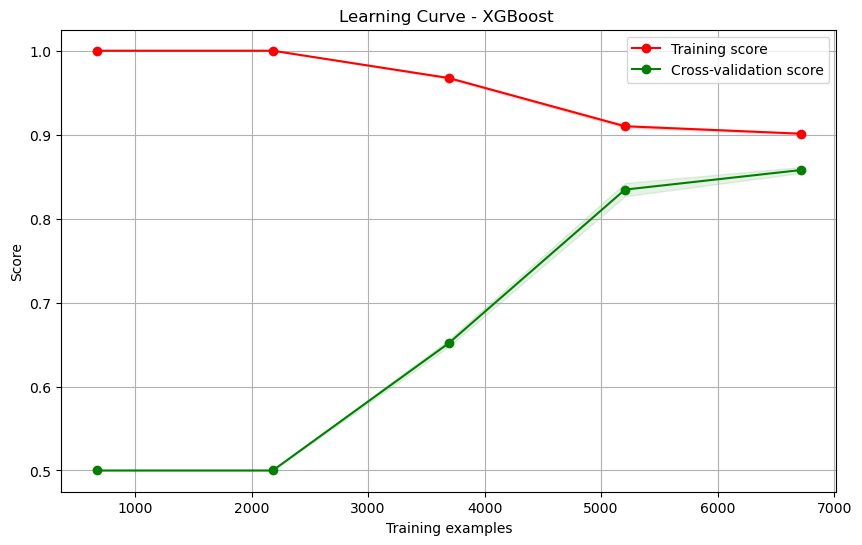

In [11]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_model_xgb, "Learning Curve - XGBoost ", X_train_under_sample_1, y_train_under_sample_1, cv=5, n_jobs=-1)
plt.show()

In [12]:
rus_5 = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # roughly a 2:1 ratio of class 0 to class 1 instances
X_train_under_sampled_5, y_train_under_sampled_5 = rus_5.fit_resample(X_train, y_train)
# Count the number of instances of each class after undersampling

print("Original class distribution:")
print("Class 0 count:", np.sum(y_train == 0))
print("Class 1 count:", np.sum(y_train == 1))

print("\nClass distribution after undersampling:")
print("Class 0 count:", len(X_train_under_sampled_5[y_train_under_sampled_5 == 0]))
print("Class 1 count:", len(y_train_under_sampled_5[y_train_under_sampled_5 == 1]))

Original class distribution:
Class 0 count: 31970
Class 1 count: 4198

Class distribution after undersampling:
Class 0 count: 8396
Class 1 count: 4198


In [13]:
xgb_model_2 = xgb.XGBClassifier()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}

# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    xgb_model_2,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the training data
grid_search.fit(X_train_under_sampled_5, y_train_under_sampled_5)

# Get the best estimator from the grid search
best_model_xgb_under_sampled_5 = grid_search.best_estimator_
best_param_xgb_under_sampled_5 = grid_search.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores_xgb_under_sampled_5 = grid_search.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val_xgb_under_sampled_5 = cross_val_recall_scores_xgb_under_sampled_5.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred_xgb_under_sampled_5 = best_model_xgb_under_sampled_5.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_param_xgb_under_sampled_5)
print("Average Recall from Cross-Validation:", avg_recall_cross_val_xgb_under_sampled_5)

# Print classification report
print(classification_report(y_test, y_pred_xgb_under_sampled_5))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Average Recall from Cross-Validation: 0.7887119019240594
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7952
           1       0.50      0.80      0.62      1091

    accuracy                           0.88      9043
   macro avg       0.74      0.85      0.77      9043
weighted avg       0.91      0.88      0.89      9043



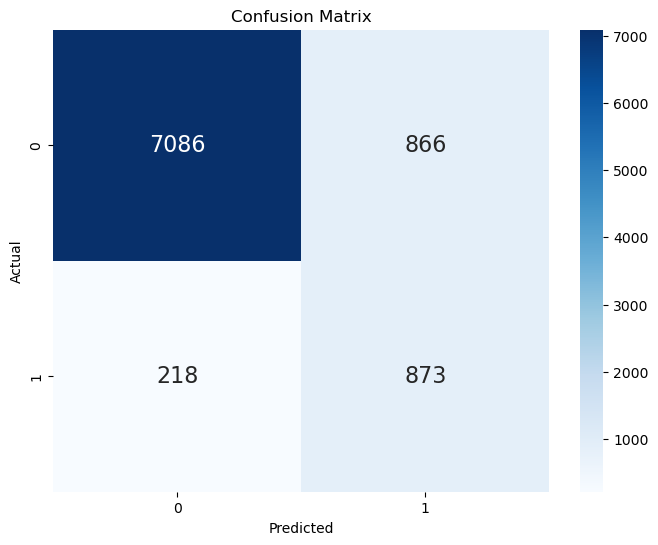

In [14]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred_xgb_under_sampled_5)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

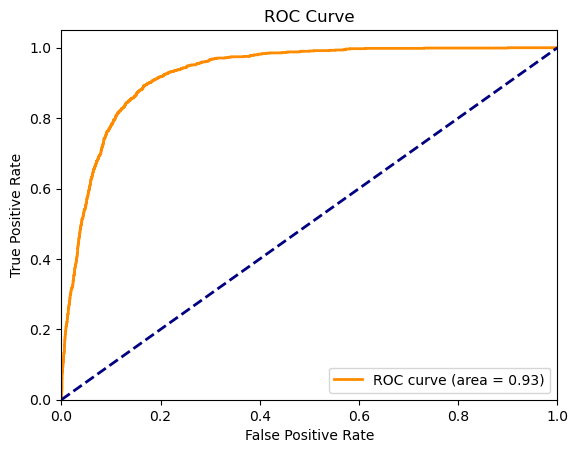

In [15]:
# lets see the ROC curve to see the model's performance at varying levels of discrimination.
y_prob = best_model_xgb_under_sampled_5.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

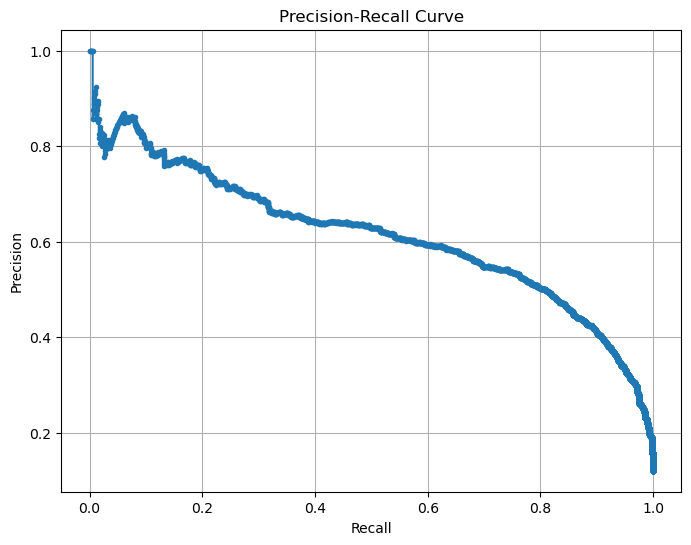

In [16]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_xgb_under_sampled_5.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

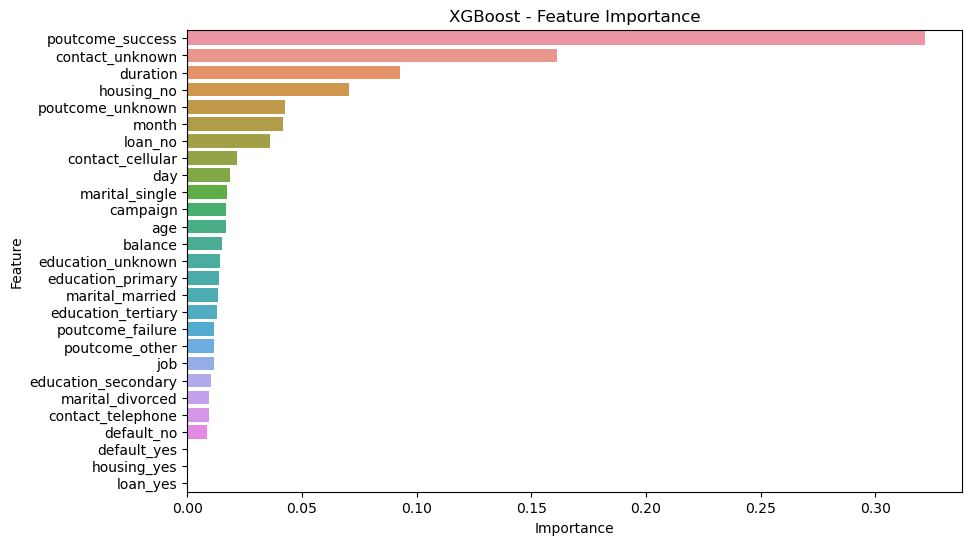

In [17]:
# lets also see the influence of each feature on the output
# Get feature importances
feature_importances = best_model_xgb_under_sampled_5.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train_under_sampled_5.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("XGBoost - Feature Importance")
plt.show()

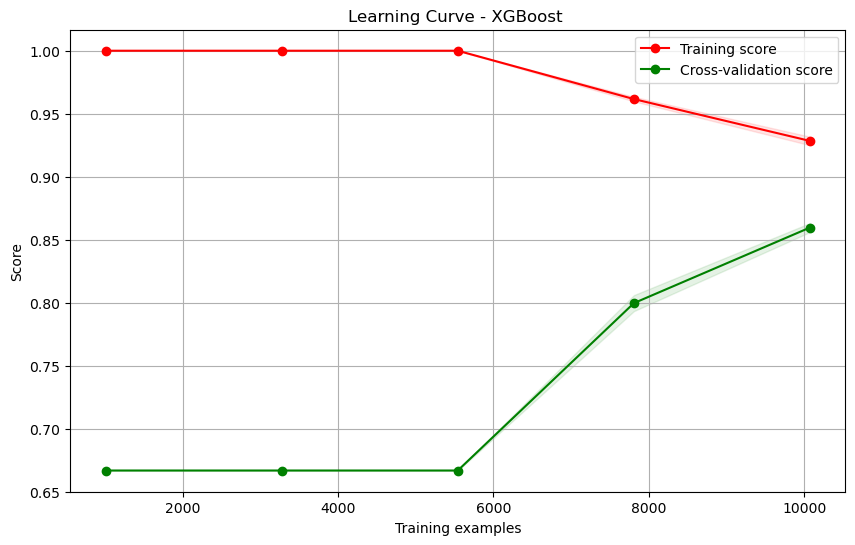

In [18]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_model_xgb_under_sampled_5, "Learning Curve - XGBoost ", X_train_under_sampled_5, y_train_under_sampled_5, cv=5, n_jobs=-1)
plt.show()

In [19]:
# Now, lets apply oversampling
smote = SMOTE(random_state=42)
X_train_over_sampled, y_train_over_sampled = smote.fit_resample(X_train, y_train)

print("Original class distribution:")
print("Class 0 count:", np.sum(y_train == 0))
print("Class 1 count:", np.sum(y_train == 1))

print("\nClass distribution after oversampling:")
print("Class 0 count:", len(X_train_over_sampled[y_train_over_sampled == 0]))
print("Class 1 count:", len(y_train_over_sampled[y_train_over_sampled == 1]))

Original class distribution:
Class 0 count: 31970
Class 1 count: 4198

Class distribution after oversampling:
Class 0 count: 31970
Class 1 count: 31970


In [20]:
xgb_model_3 = xgb.XGBClassifier()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}

# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    xgb_model_3,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the training data
grid_search.fit(X_train_over_sampled, y_train_over_sampled)

# Get the best estimator from the grid search
best_model_xgb_over_sampled = grid_search.best_estimator_
best_param_xgb_over_sampled = grid_search.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores_xgb_over_sampled = grid_search.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val_xgb_over_sampled = cross_val_recall_scores_xgb_over_sampled.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred_xgb_over_sampled = best_model_xgb_over_sampled.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_param_xgb_over_sampled)
print("Average Recall from Cross-Validation:", cross_val_recall_scores_xgb_over_sampled)

# Print classification report
print(classification_report(y_test, y_pred_xgb_over_sampled))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}
Average Recall from Cross-Validation: [0.88811386 0.88958398 0.88814514 0.89164842 0.8824523  0.87907413
 0.89480763 0.89487019 0.8942446  0.89121051 0.90315921 0.90200188
 0.91273069 0.91460744 0.91413825 0.91260557 0.92123866 0.92177041
 0.91335627 0.91366906 0.92126994 0.92377229 0.91251173 0.90910228]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      7952
           1       0.50      0.72      0.59      1091

    accuracy                           0.88      9043
   macro avg       0.73      0.81      0.76      9043
weighted avg       0.90      0.88      0.89      9043



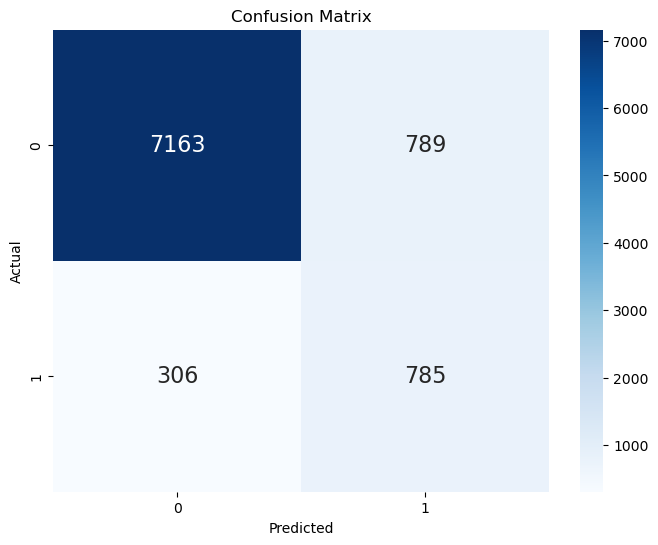

In [21]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred_xgb_over_sampled)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

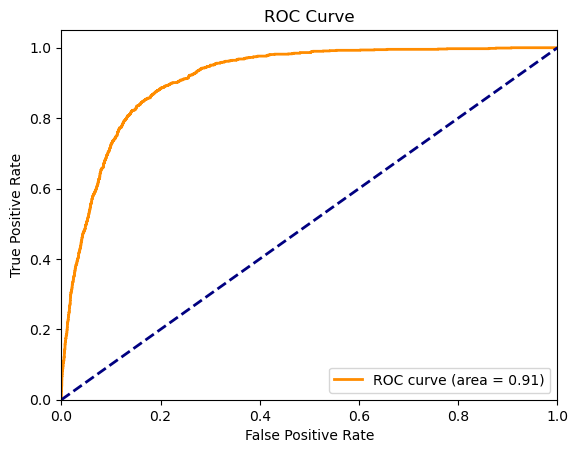

In [22]:
# lets see the ROC curve to see the model's performance at varying levels of discrimination.
y_prob = best_model_xgb_over_sampled.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

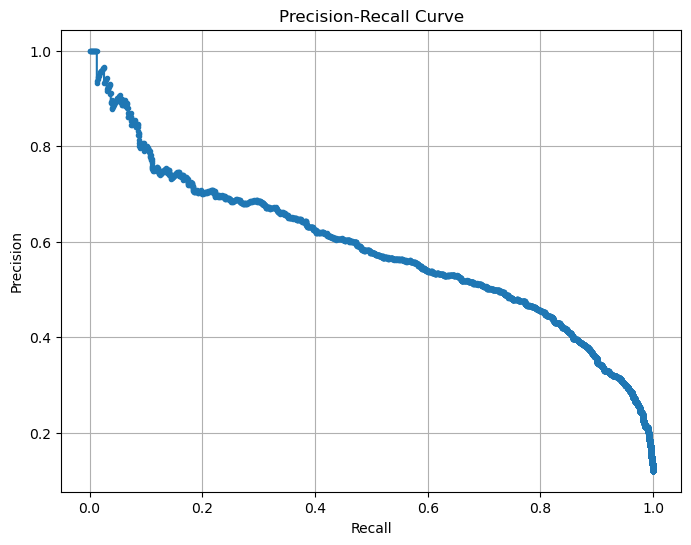

In [23]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_xgb_over_sampled.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

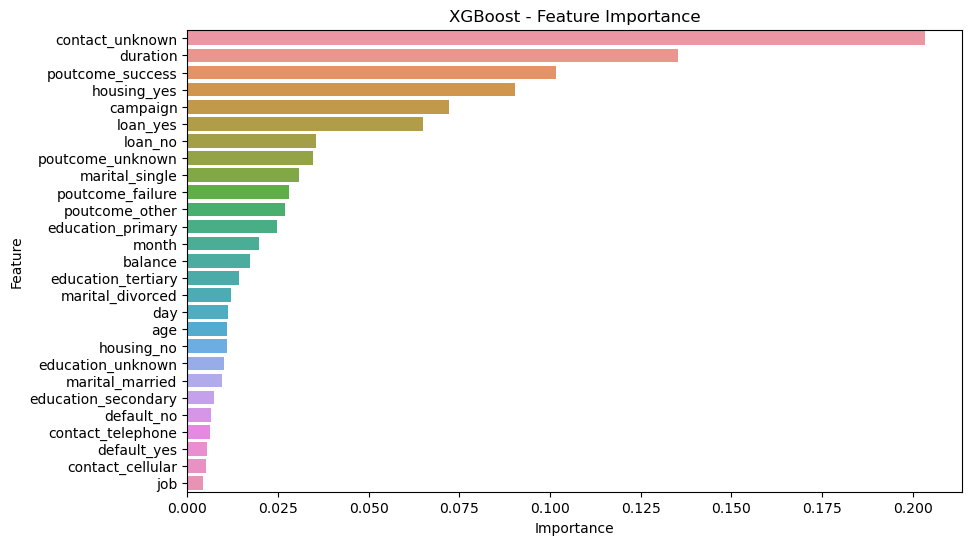

In [24]:
# lets also see the influence of each feature on the output
# Get feature importances
feature_importances = best_model_xgb_over_sampled.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train_over_sampled.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("XGBoost - Feature Importance")
plt.show()

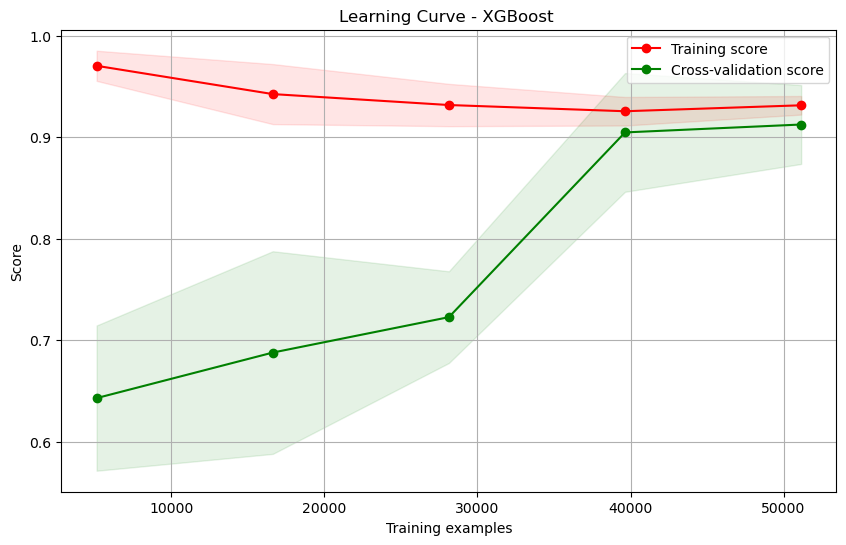

In [25]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_model_xgb_over_sampled, "Learning Curve - XGBoost ", X_train_over_sampled, y_train_over_sampled, cv=5, n_jobs=-1)
plt.show()

In [26]:
xgb_model_4 = xgb.XGBClassifier()

# Define the parameter grid for grid search
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]
}

# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    xgb_model_4,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_model_xgb_weight = grid_search.best_estimator_
best_param_xgb_weight = grid_search.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores_xgb_weight = grid_search.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val_xgb_weight = cross_val_recall_scores_xgb_weight.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred_xgb_weight = best_model_xgb_weight.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_param_xgb_weight)
print("Average Recall from Cross-Validation:", cross_val_recall_scores_xgb_weight)

# Print classification report
print(classification_report(y_test, y_pred_xgb_weight))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'scale_pos_weight': 7.615531205335874, 'subsample': 1.0}
Average Recall from Cross-Validation: [0.85064561 0.85636046 0.83849878 0.83658919 0.828488   0.82872723
 0.84230433 0.8399248  0.83754157 0.83611584 0.8458803  0.84826409
 0.86326863 0.8639832  0.87493984 0.87494154 0.87517822 0.87518049
 0.87065526 0.86922697 0.85469436 0.85897838 0.83420682 0.83587548]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7952
           1       0.41      0.87      0.56      1091

    accuracy                           0.83      9043
   macro avg       0.69      0.85      0.73      9043
weighted avg       0.91      0.83      0.85      9043



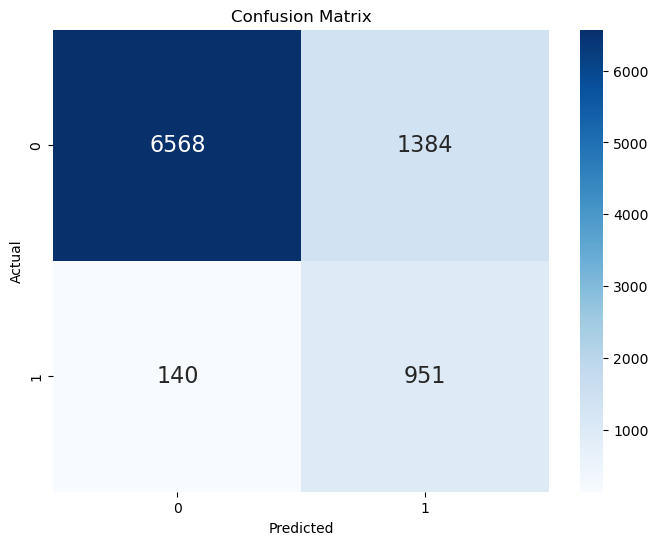

In [27]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred_xgb_weight)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

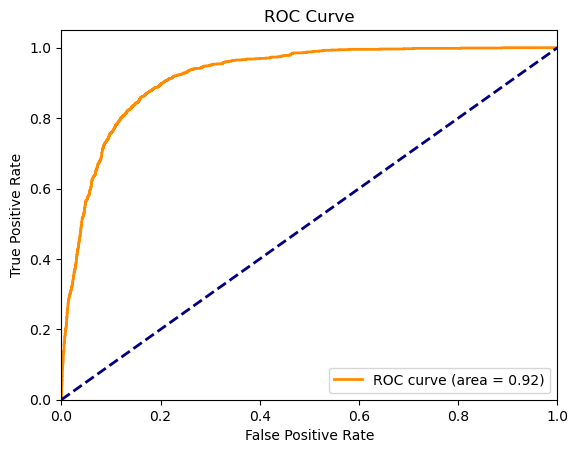

In [28]:
# lets see the ROC curve to see the model's performance at varying levels of discrimination.
y_prob = best_model_xgb_weight.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

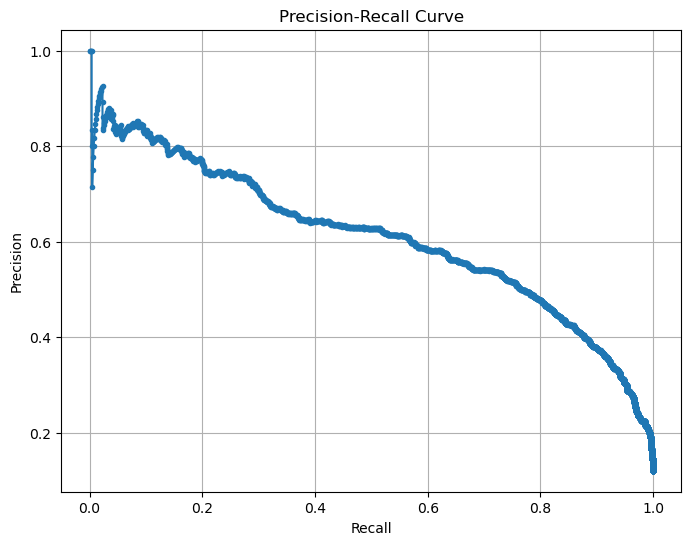

In [29]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_xgb_weight.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

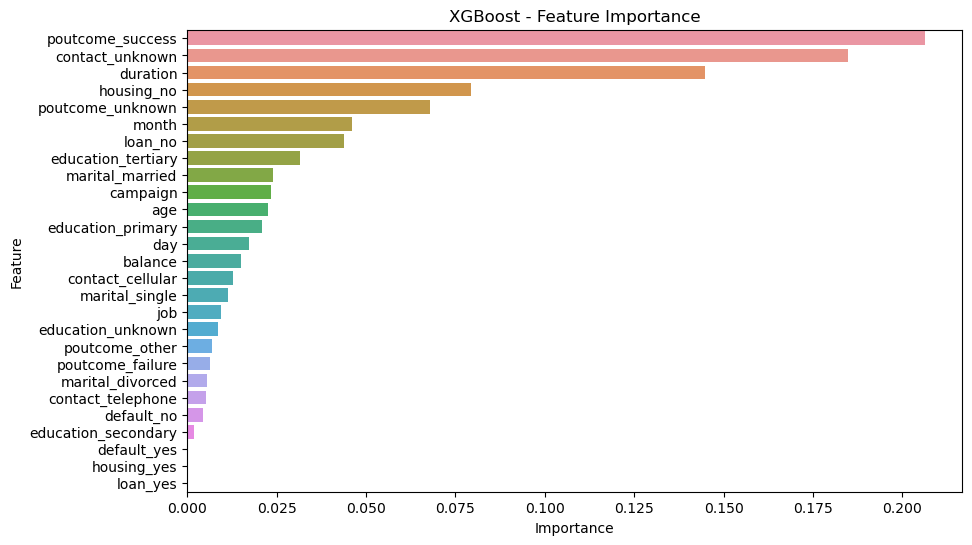

In [30]:
# lets also see the influence of each feature on the output
# Get feature importances
feature_importances = best_model_xgb_weight.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("XGBoost - Feature Importance")
plt.show()

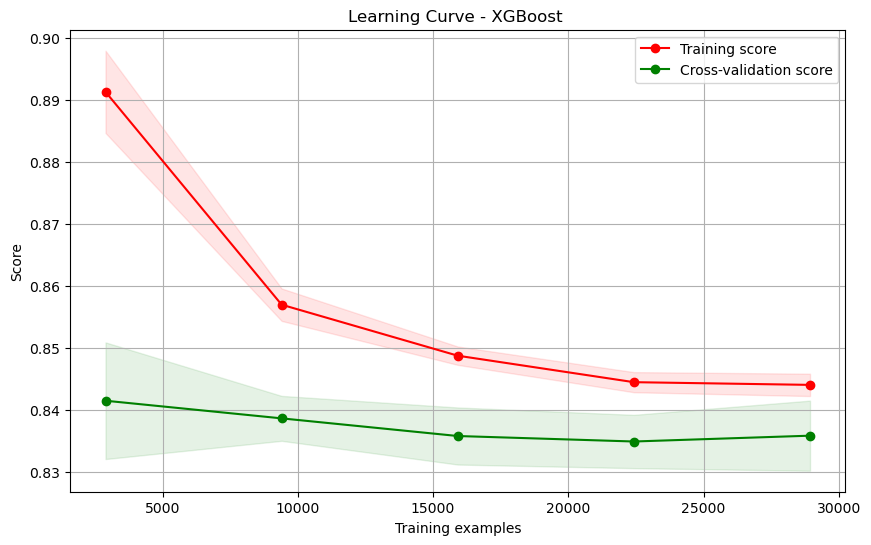

In [31]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt


plot_learning_curve(best_model_xgb_weight, "Learning Curve - XGBoost ", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

In [32]:
# save the model for further investigation and usage in future
joblib.dump(best_model_xgb, 'best_model_xgb_under_sample_with_1_to_1_ratio.pkl')
joblib.dump(best_model_xgb_under_sampled_5, 'best_model_xgb_under_sample_with_2_to_1_ratio.pkl')
joblib.dump(best_model_xgb_over_sampled, 'best_model_xgb_over_sample.pkl')
joblib.dump(best_model_xgb_weight, 'best_model_xgb_weight_adjustion.pkl')

['best_model_xgb_weight_adjustion.pkl']